In [1]:
import h5py
import cv2
import os
import numpy as np
import torch
import pywt

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
params = {
    'log_file': 'ResNet_smallNorb',
    'n_epoch': 200,
    'n_batch': 64,
    'lr': 0.001,
    'n_class': 200,
    'img_size': (1, 128, 128),
    'device': 'cuda:1',
    'lr_decay': 0.9,
    'lr_step': 100
}

torch.cuda.set_device(params['device'])
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device=torch.device(params['device'])
torch.cuda.manual_seed(1)

In [3]:
class SmallNorbread(Dataset):
    def __init__(self, name, degrade_fn = None, transform=None):
        hf = h5py.File(name, 'r')
        input_images = np.array(hf.get('data')).astype(np.uint8)
        self.input_images = input_images / 255.
        self.target_labels = np.array(hf.get('labels')).astype(np.long)

        self.transform = transform
        self.degrade_fn = degrade_fn
        hf.close()

    def __len__(self):
        return (self.input_images.shape[0])

    def __getitem__(self, idx):
        images = self.input_images[idx]
        o_images = images.copy()
        o_images = (o_images - np.min(o_images)) / (np.max(o_images) - np.min(o_images))
        classes = self.target_labels[idx]
        
        if self.degrade_fn is not None:
            images = self.degrade_fn(images)
            images = (images - np.min(images)) / (np.max(images) - np.min(images))
        
        if self.transform is not None:

            images = self.transform(images.astype(np.float32))
            o_images = self.transform(o_images.astype(np.float32))
        
        return o_images, images, classes

# add noise

In [4]:
def Gaussian_noise(img):

    noise_model = np.random.normal(0, 0.1, img.shape)
    noise_img = img + noise_model
    
    return noise_img

def salt_pepper_noise(img):
   
    noise_model = np.random.choice([0, 1], size=img.shape, p=[0.5, 0.5])
    m = np.random.choice([0, 1], size=img.shape, p=[0.9, 0.1])
    noise_img = (1 - m) * img + m * noise_model
    
    return noise_img

def speckle_noise(img):
    
    noise_model = np.random.uniform(-0.1, 0.1, img.shape)        
    noise_img  = img *(1 + noise_model)
    
    return noise_img 

def add_noise(img):
    
    noise_type = np.random.randint(3)
    if(noise_type == 0):
        return Gaussian_noise(img)
    elif(noise_type == 1):
        return salt_pepper_noise(img)
    elif(noise_type == 2):
        return speckle_noise(img)

# lower resolution

In [5]:
def wavelets_transform(img, level = 1):
    
    LLs = []
    LHs = []
    HLs = []
    HHs = []
    s = img.shape[0]
    imgs = np.zeros((s,s))
    
    for i in range(level):
        coeffs2 = pywt.dwt2(img, 'haar')
        LL, (LH, HL, HH) = coeffs2
        LLs.append(LL)
        LHs.append(LH)
        HLs.append(HL)
        HHs.append(HH)
        img = LL
    
    low_img = cv2.resize(LL, (s, s), interpolation = cv2.INTER_AREA)
    
    return low_img

def reduce_resolution(img):
    
    level = np.random.randint(2)
    return wavelets_transform(img, level = level + 1)
  

# Motion bluring

In [6]:
def Motion_model(w, h, a=0.1, b=0.1, T=1):
    u, v = np.meshgrid(np.arange(-h//2, h//2), np.arange(-w//2, w//2))
    phi = np.pi * (u * a + v * b) + 10e-6
    ft = (T / phi) * np.sin(phi) * np.exp(- phi * 1j)
    
    return ft

def Motion_blurring(img):
    
    
    a = np.random.normal(0, 0.05)
    b = np.random.normal(0, 0.05)
    
    w, h = img.shape[:]
    
    H = Motion_model(w, h, a, b)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift[h//2-1:h//2+1, w//2-1:w//2+1] = 0  
    
    gshift = fshift * H
    g = np.fft.ifftshift(gshift)
    
    out = np.fft.ifft2(g)
    
#     magnitude_spectrum = 20*np.log(np.abs(gshift) + 10e-6)
    
    out = out.real
    out = out
    
    return out



In [10]:
data_path = os.path.dirname(os.getcwd()) + "/data/"

Train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees = 5, translate = (0.05, 0.05)),
        transforms.ColorJitter(brightness=0.01, contrast = 0.2),
        transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
        transforms.Normalize(mean = (0.5,), std = (0.5,))
        ])
        
Test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
        transforms.Normalize(mean = (0.5,), std = (0.5,))
    ])

Train_data = SmallNorbread(name=data_path + "smallNorb/smallNorb_train96.h5", transform=Train_transform)
Val_data = SmallNorbread(name=data_path + "smallNorb/smallNorb_test96.h5", degrade_fn = add_noise, transform=Test_transform)
Test_data = SmallNorbread(name=data_path + "smallNorb/smallNorb_test96.h5", transform=Test_transform)

Train_dataloader = DataLoader(dataset=Train_data, batch_size = params['n_batch'], shuffle=True)
Val_dataloader = DataLoader(dataset=Val_data, batch_size = params['n_batch'], shuffle=False)
Test_dataloader = DataLoader(dataset=Test_data, batch_size = params['n_batch'], shuffle=False)

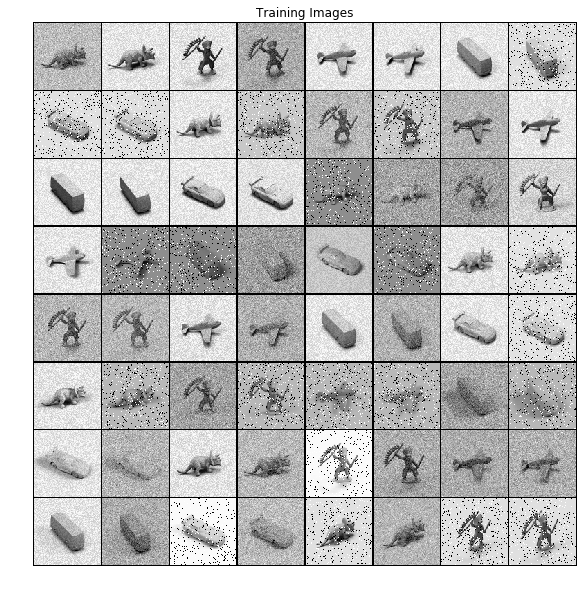

In [11]:
real_batch = next(iter(Val_dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

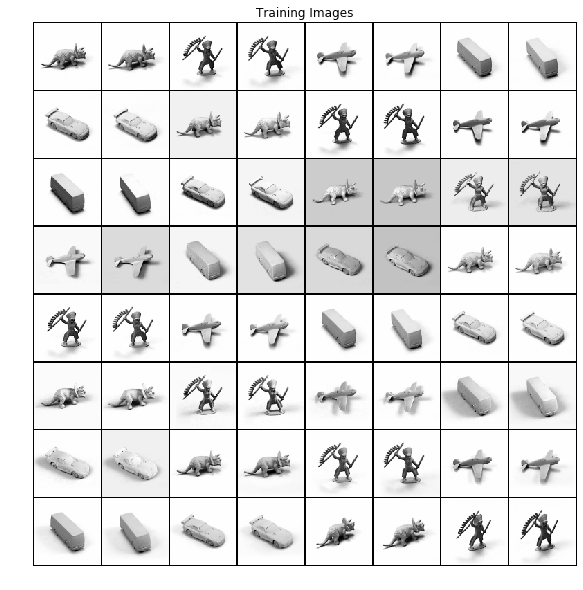

In [12]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))